<a href="https://colab.research.google.com/github/zyythn/Assignment-MV/blob/main/q5_groupedconvnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(), # convert to 4d-tensor
     transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])]
)

train_dir = '/content/drive/MyDrive/MV/tom and jerry/train'
test_dir = '/content/drive/MyDrive/MV/tom and jerry/test'

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=transform)

In [ ]:
class_names = train_data.classes
class_names

['jerry', 'no tom jerry', 'tom', 'tom jerry']

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data,batch_size=4, shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=4, shuffle=False)

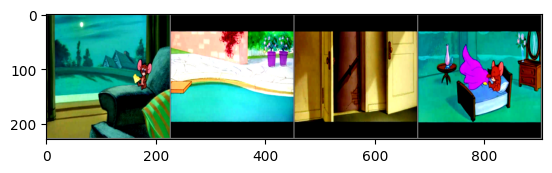

jerry no tom jerry no tom jerry jerry


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Visualize our dataset
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [ ]:
train_imgBatch, train_labelBatch = next(iter(train_dataloader))

train_imgBatch.shape

torch.Size([4, 3, 224, 224])

In [ ]:
class GroupedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups)

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
# Define our model
class GroupedConvNet(nn.Module):
    def __init__(self):
        super(GroupedConvNet, self).__init__()
        self.conv1 = GroupedConv(in_channels=3, out_channels=6, kernel_size=5, groups=3)  # Grouped Convolution with 3 groups
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = GroupedConv(6, 16, 5, groups=2)  # Grouped Convolution with 2 groups
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = GroupedConv(16, 20, 3, groups=4)  # Grouped Convolution with 4 groups
        self.fc1 = nn.Linear(52020, 2880)
        self.fc2 = nn.Linear(20 * 12 * 12, 4)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.dropout = nn.Dropout(0.4)  # drop 40% of neurons during training

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        out = self.fc2(x)

        return out

In [ ]:
model = GroupedConvNet()

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model = model)

Layer (type:depth-idx)                   Param #
GroupedConvNet                           --
├─GroupedConv: 1-1                       --
│    └─Conv2d: 2-1                       156
├─MaxPool2d: 1-2                         --
├─GroupedConv: 1-3                       --
│    └─Conv2d: 2-2                       1,216
├─MaxPool2d: 1-4                         --
├─GroupedConv: 1-5                       --
│    └─Conv2d: 2-3                       740
├─Linear: 1-6                            149,820,480
├─Linear: 1-7                            11,524
├─ReLU: 1-8                              --
├─Flatten: 1-9                           --
├─BatchNorm2d: 1-10                      12
├─BatchNorm2d: 1-11                      32
├─Dropout: 1-12                          --
Total params: 149,834,160
Trainable params: 149,834,160
Non-trainable params: 0

In [ ]:
# cross-entropy loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
model.to('cuda')

GroupedConvNet(
  (conv1): GroupedConv(
    (conv): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), groups=3)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): GroupedConv(
    (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), groups=2)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): GroupedConv(
    (conv): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), groups=4)
  )
  (fc1): Linear(in_features=52020, out_features=2880, bias=True)
  (fc2): Linear(in_features=2880, out_features=4, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

In [ ]:
num_epochs = 10
trained_GroupedConvNet, history = train_and_validate(model,loss_fn,optimizer,
                                            train_dataloader,test_dataloader,
                                            num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.2248, Accuracy: 93.3521%, 
		Validation : Loss : 2.1751, Accuracy: 34.6460%, Time: 645.0052s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.1284, Accuracy: 96.5351%, 
		Validation : Loss : 2.6002, Accuracy: 35.4018%, Time: 70.6995s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.1058, Accuracy: 97.5020%, 
		Validation : Loss : 2.8066, Accuracy: 37.9475%, Time: 71.3681s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.0859, Accuracy: 98.2272%, 
		Validation : Loss : 2.4900, Accuracy: 33.6913%, Time: 71.2918s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.0677, Accuracy: 98.1869%, 
		Validation : Loss : 2.9317, Accuracy: 36.5155%, Time: 71.5730s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.0484, Accuracy: 98.6704%, 
		Validation : Loss : 3.1978, Accuracy: 38.2259%, Time: 71.2637s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0622, Accuracy: 98.6301%, 
		Validation : Loss : 2.9321, Accuracy: 35.8791%, Time: 71.4424s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0555, Accur

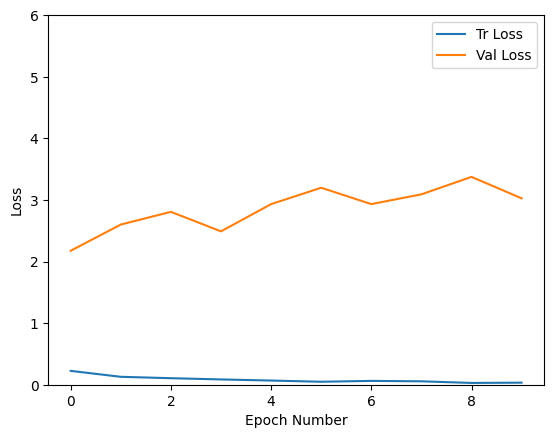

In [ ]:
def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss']) #tr loss = training loss, val loss = validation loss
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,6)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

plot_loss(history)

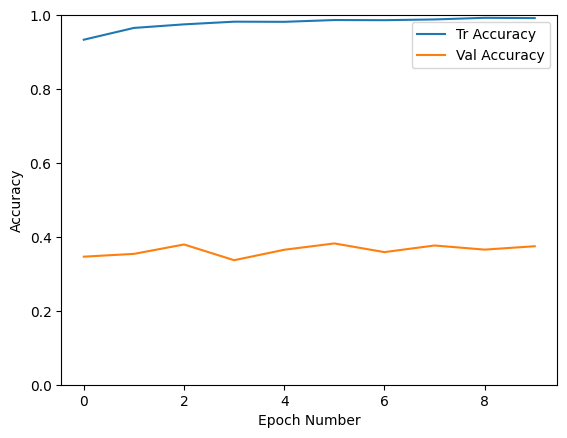

In [ ]:
def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

plot_accuracy(history)